# INF264 - Project 2: Digit Recognizer
> **Name:** Trym Døssland Bjerkvik <br>
> **Date:** 20.10.2023

A machine learning project for building a classifier for recognizing handwritten hexadecimal digits from images as part of the INF264 course.



## Table of Contents
- [1. Framing the Problem](#1.-Framing-the-Problem)
- [2. Data Acquisition](#2.-Data-Acquisition)
- [3. Data Exploration](#3.-Data-Exploration)
- [4. Data Preprocessing](#4.-Data-Preprocessing)
- [5. Model Exploration and Selection](#5.-Model-Exploration-and-Selection)
- [6. Model Fine-tuning](#6.-Model-Fine-tuning)
- [7. Evaluation and Results](#7.-Evaluation-and-Results)


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from fastai.vision.all import *
from pathlib import Path
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.dummy import DummyClassifier
import timm
from fastai.metrics import DiceMulti, BalancedAccuracy

# Setting to display plots directly below the code cell.
%matplotlib inline

## 1. Framing the Problem

"As December draws near, Santa is concerned about meeting the gift preparation deadline for all the children. The Chief Elf Officer (CEO) of Santa’s Workshop has reached out to you, a prominent machine learning expert, to enhance the efficiency of the sorting process. Your mission is to create an advanced automated gift recognition system that could potentially save Christmas this year." (Project Description, INF264).

Each gift is marked with a unique handwritten hexadecimal digit, either a number from 0 to 9 or a letter from A to F, indicating its type. However, there are instances when the elves might forget to label certain gifts.

From a technical standpoint, this scenario presents a multi-class classification problem. The primary objective is to design and build a reliable classifier that can correctly identify the corresponding label for each gift and detect unlabeled gifts.

## 2. Data Acquisition

#### 2.1 Loading the Data

In [2]:
# Load the data.
X = np.load("emnist_hex_images.npy")
y = np.load("emnist_hex_labels.npy")

#### 2.2 Splitting the Data

In [3]:
# Splitting the data into training and test sets.
# Using stratify=y to make the training and test sets have roughly the same class distribution. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (86241, 400)
y_train shape: (86241,)
X_test shape: (21561, 400)
y_test shape: (21561,)


## 3. Data Exploration

#### 3.1 Visualizing Data Samples

In [5]:
print(f"Number of images in X_train: {X_train.shape[0]}")
print(f"Number of labels in y_train: {y_train.shape[0]}")
print(f"Number of features/pixels per image: {X_train.shape[1]}")

Number of images in X_train: 86241
Number of labels in y_train: 86241
Number of features/pixels per image: 400


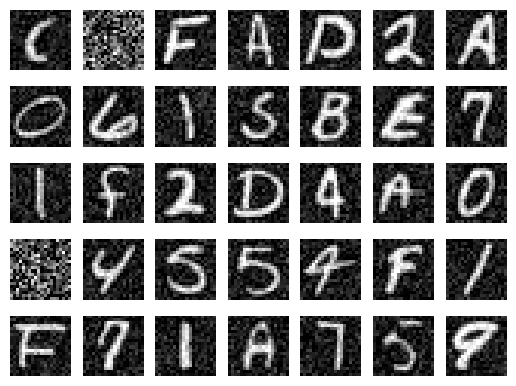

In [6]:
# Show the 35 first images from X_train.
# Create a figure with 5 rows and 7 columns.
fig, axes = plt.subplots(5, 7)

# Flatten the 2D grid of axes into a 1D array.
axes = axes.ravel()

# Loop through the first 35 images.
for i, ax in enumerate(axes):
    # Reshape the image to 20x20.
    image = X_train[i].reshape(20, 20)
    
    # Display the image in grayscale.
    ax.imshow(image, cmap='gray')
    
    # Hide axis.
    ax.axis('off')
    
# Show the figure.
plt.show()

#### 3.2 Visualizing Data by Class

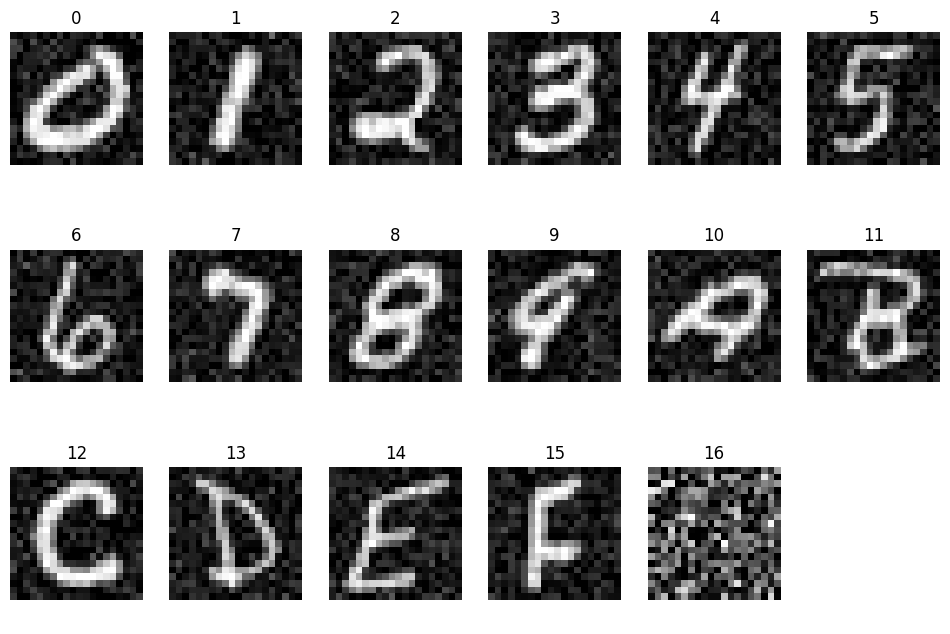

In [7]:
# Display a random sample for each class (0 to 16).

# Create a figure with a 3x6 grid, and total size to 12x8.
fig, axes = plt.subplots(3, 6, figsize=(12, 8))

# Flatten the 2D array of axes into a 1D array.
axes = axes.ravel()

# Set a fixed seed for reproducibility.
np.random.seed(42)

# For each class label from 0 to 16.
for class_label in range(17):
    # Get indices of the specified class.
    class_indices = np.where(y_train == class_label)[0]
    
    # Randomly select one index from the class. 
    random_index = np.random.choice(class_indices)
    
    # Reshape the images to 20x20.
    image = X_train[random_index].reshape(20, 20)
    
    # Display the reshaped image in grayscale.
    axes[class_label].imshow(image, cmap='gray')
    
    # Turn off the axis markings.
    axes[class_label].axis('off')
    
    # Set the title to be its class label.
    axes[class_label].set_title(str(class_label))
    
# Remove the last empty axis.
axes[-1].axis('off')

# Show the plot. 
plt.show()

We can see a that the dataset contains handdrawn numers, letters, and some empty (noisy) images.

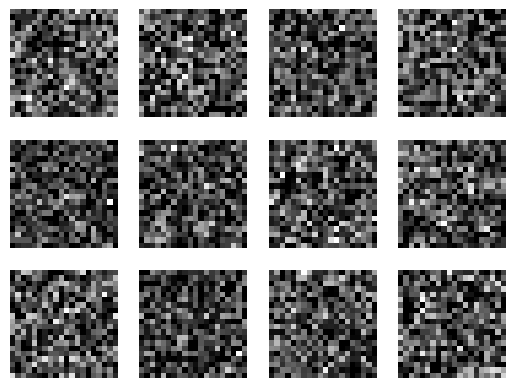

In [8]:
# Display the 12 first empty images (label 16) from X_train. 
fig, axes = plt.subplots(3, 4)
axes = axes.ravel()

# Filter X_train to only get images with label 16.
img = X_train[y_train == 16]

# Iterate over the first 12 empty images and display them.
for i, ax in enumerate(axes):
    image = img[i].reshape(20, 20)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

#### 3.3 Class Distribution Analysis

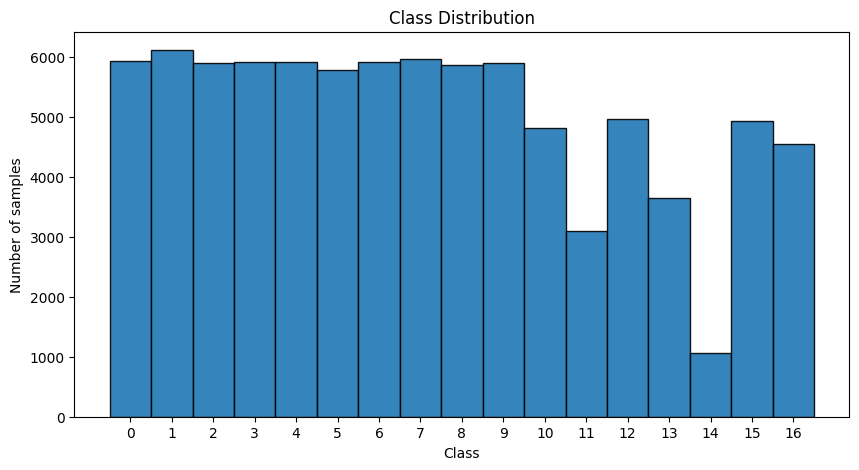

In [9]:
plt.figure(figsize=(10, 5))

# Plot a histogram showing the distribution of classes in y_train.
# Adjust bins to align with class labels, and give an edgecolor for easier seperation.
plt.hist(y_train, bins=np.arange(18)-0.5, edgecolor="black", alpha=0.9)

# Set the x-axis label, y-axis label, and title.
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Class Distribution")

# Set the x-axis tics to display every number from 0 to 16.
plt.xticks(np.arange(17))
plt.show()

* The dataset appears to be relatively balanced for the numbers 0 to 9. The hexadecimal characters A to F have fewer instances than the numbers.
* B (label 11) at around 3000 instances, D (label 13) at around 3500 instances, and E (14) at around 1000 instances are notably smaller than the rest of the dataset.
* The empty images (label 16) are fairly big at a similar size as most hexadecimal characters.
* Given fewer samples for B, D and E, the model might perform worse in predicting these characters, especially on D.
* Might consider making the dataset more balanced by using techniques like SMOTE or using a weighted loss function.
* Because the dataset is slightly imbalanced, metrics like F1-score and precision might be a better choice than accuracy.

#### 3.4 Data Integrity Checks

In [10]:
# Find indices of images where all the pixels has the value 0.
empty_images = np.where(np.all(X == 0, axis=1))[0]

# Find indices of images where all the pixel values are the same.
constant_images = np.where(np.apply_along_axis(lambda x: len(np.unique(x)), 1, X) == 1)[0]

# Find indices of labels that are not in the range 0 to 16.
invalid_labels = np.where((y < 0) | (y > 16))[0]

print(f"Number of all-zero images: {len(empty_images)}")
print(f"Number of constant-value images: {len(constant_images)}")
print(f"Number of invalid labels: {len(invalid_labels)}")

# Calculate the mean and standard deviation of pixel values for each image.
image_means = X.mean(axis=1)
image_std_devs = X.std(axis=1)

# Find images with a mean pixel value higher than 200.
suspicious_images = np.where(image_means > 200)[0]
print(f"Number of potentially corrupted images: {len(suspicious_images)}")

Number of all-zero images: 0
Number of constant-value images: 0
Number of invalid labels: 0
Number of potentially corrupted images: 0


## 4. Data Preprocessing

#### 4.1 Preparing Data for Traditional Models

In [11]:
# Create a StandardScaler to normalize the data.
scaler = StandardScaler()

# Fit the scaler using the training data.
scaler.fit(X_train)

# Transform the training and test data.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4.2 Preparing Data for CNN

In [12]:
# Reshaping the flat pixel arrays into 20x20 image matrices.
X_train_reshaped = X_train.reshape(-1, 20, 20)
X_test_reshaped = X_test.reshape(-1, 20, 20)

# Set the directory paths where training and test images will be saved.
training_data = Path("./train")
test_data = Path("./test")

# NOTE: The below code is used to save training and testing images as png files.
# These are used when training the CNN models. 
# SAVE_IMAGES determine whether to create png files or not.
SAVE_IMAGES = True
if SAVE_IMAGES:
    # Save training images to the specified training directory.
    for i, (label, image) in enumerate(zip(y_train, X_train_reshaped)):
        
        # Check if the label directory exists. Create it if not.
        (training_data / str(label)).mkdir(parents=True, exist_ok=True)
        
        # Save the image with its index as the filename.
        plt.imsave(training_data / str(label) / f"{i}.png", image, cmap="gray")

    # Save testing images to the specified training directory (same as above, but for test dataset).
    for i, (label, image) in enumerate(zip(y_test, X_test_reshaped)):
        (test_data / str(label)).mkdir(parents=True, exist_ok=True)
        plt.imsave(test_data / str(label) / f"{i}.png", image, cmap="gray")

## 5. Model Exploration and Selection

In [13]:
# Set random seeds for reproducibility.
seed = 42
torch.manual_seed(seed) # PyTorch.
torch.cuda.manual_seed_all(seed) # GPU devices.
torch.backends.cudnn.deterministic = True # Make CuDNN backend deterministic.
torch.backends.cudnn.benchmark = False # Turn off CuDNN benchmarking.

In [14]:
def train_cnn_model(model_name="resnet18", num_classes=17, seed=42):
    """Trains a CNN model using the given architecture.
    
    Args:
        model_name (str): Name of the CNN architecture.
        num_classes (int): Number of classes (labels).
        seed (int): Random seed.
        
    Returns:
        dict: Dictionary containing macro F1 score, balanced accuracy, and the trained learner.
    
    Raises:
        ValueError: If the provided model_name is not implemented. 
    
    """
    
    # Setup batch transforms to apply to the images. Here, normalize images using ImageNet statistics.
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    
    # Set batch size.
    bs = 256
    
    # Load the data from the training data folder. Using seed and without shuffeling for consistency.
    dls = ImageDataLoaders.from_folder(training_data, valid_pct=0.2, seed=seed, batch_tfms=batch_tfms, bs=bs, shuffle_train=False)

    # Choose model architecture and setup the learner. Using pre-trained weights by default for reproducibility. 
    if model_name == "resnet18":
        learn = vision_learner(dls, "resnet18", metrics=[F1Score(average='macro'), BalancedAccuracy()])
    elif model_name == "efficientnetv2":
        # Ise timm to get the specified achitecture.
        model = timm.create_model("tf_efficientnetv2_s", pretrained=True, num_classes=num_classes)
        learn = Learner(dls, model, metrics=[F1Score(average='macro'), BalancedAccuracy()])
    else:
        raise ValueError("Invalid mode_name.")

    # Train the model for 2 epochs. Supress progress bars and logs. Using default learning rate (0.001).
    with learn.no_bar(), learn.no_logging():
        learn.fine_tune(2)
    
    # Get the models predictions on the validation set.
    preds, targs = learn.get_preds()

    # Convert prediction scores to class labels.
    preds = preds.argmax(dim=1)
    
    # Calculate evaluation metrics.
    f1 = f1_score(targs, preds, average='macro')
    bal_acc = balanced_accuracy_score(targs, preds)
    
    # Return evaluation metrics and the trained learner.
    return {"f1_macro": f1, "balanced_accuracy": bal_acc, "learner": learn}

In [15]:
def classificationScores(estimator):
    """Computes the f1_macro and balanced_accuracy cross-validation metrics for an estimator.
    
    Args:
        estimator (object): The classifier to evaluate.
    
    Returns:
        dict: A dictionary containing cross-validated scores for f1 macro and balanced accuracy.
    
    """
    
    # Define the K-fold cross validation with 5 splits.
    kf = KFold(5).get_n_splits(X_train)
    
    # Create list of metrics to be used.
    metrics = ["f1_macro", "balanced_accuracy"]
    
    # Perform cross validation and get evaluation scores.
    scores = cross_validate(estimator, X_train_scaled, y_train, scoring=metrics, cv=kf, return_train_score=False)
    
    # Extract the scores for each metric from the result.
    f1_scores = scores['test_f1_macro']
    balanced_accuracy_scores = scores['test_balanced_accuracy']
    
    # Return both evaluation metrics.
    return {
        "f1_macro": f1_scores,
        "balanced_accuracy": balanced_accuracy_scores
    }

In [16]:
# Define a list of classifiers and their names.
classifiers = [
    # Dummy Classifier predicts the majority class. Gives a minimum performance threshold. 
    (DummyClassifier(strategy="most_frequent"), "Dummy Classifier"),
    ("efficientnetv2", "efficientnetv2"),
    ("resnet18", "resnet18"),
    (XGBClassifier(n_jobs=-1, random_state=42, use_label_encoder=False), "XGBoost"),
    (LogisticRegression(n_jobs=-1), "Logistic Regression"),
    (RandomForestClassifier(n_jobs=-1, random_state=42), "Random Forest"),
    (KNeighborsClassifier(n_jobs=-1), "k-Nearest Neighbors")
]

# Define initial best scores, models, and names.
best_traditional_score = 0
best_cnn_score = 0

best_traditional_model = None
best_cnn_model = None

best_traditional_name = ""
best_cnn_name = ""

# Define the metric used for model selection.
selection_metric = "f1_macro"

# Loop through each classifier, evaluate and print its performance.
# NOTE: RUN determine whether to run the comparison or not.
RUN = True
if RUN:
    print("-"*50)
    for clf, clf_name in classifiers:
        
        # Get the start time to track training time.
        start_time = time.time()
        
        # Check if the current classifier is a CNN model.
        if clf_name in ["resnet18", "efficientnetv2"]:
            results = train_cnn_model(model_name=clf_name)
            scores = {"f1_macro": [results["f1_macro"]],
                     "balanced_accuracy": [results["balanced_accuracy"]]}
            
            # If current model performs better, update best CNN model details.
            if np.mean(scores[selection_metric]) > best_cnn_score:
                best_cnn_score = np.mean(scores[selection_metric])
                best_cnn_model = results["learner"]
                best_cnn_name = clf_name
        
        # Else it is a traditional classifier.
        else:
            scores = classificationScores(clf)
            
            # If current model performs better, update best traditional model details.
            if np.mean(scores[selection_metric]) > best_traditional_score:
                best_traditional_score = np.mean(scores[selection_metric])
                best_traditional_model = clf
                best_traditional_name = clf_name
                
        # Calculate the training time.
        elapsed_time = time.time() - start_time

        # Print performance metrics and training time for the current model.
        print(f"{clf_name} - Macro F1: {np.mean(scores['f1_macro'])*100:6.2f}%")
        print(f"{clf_name} - Balanced Accuracy: {np.mean(scores['balanced_accuracy'])*100:6.2f}%")
        print(f"{clf_name} - Training Time: {elapsed_time:.2f} seconds")
        print("-"*50)

    # Print the overall best CNN model and traditional model. 
    print(f"The best traditional model based on {selection_metric} is {best_traditional_name} with a score of {best_traditional_score*100:6.2f}%")
    print(f"The best CNN model based on {selection_metric} is {best_cnn_name} with a score of {best_cnn_score*100:6.2f}%")

--------------------------------------------------
Dummy Classifier - Macro F1:   0.78%
Dummy Classifier - Balanced Accuracy:   5.88%
Dummy Classifier - Training Time: 0.26 seconds
--------------------------------------------------


efficientnetv2 - Macro F1:  98.44%
efficientnetv2 - Balanced Accuracy:  98.44%
efficientnetv2 - Training Time: 499.49 seconds
--------------------------------------------------


resnet18 - Macro F1:  89.39%
resnet18 - Balanced Accuracy:  89.10%
resnet18 - Training Time: 238.85 seconds
--------------------------------------------------
XGBoost - Macro F1:  94.48%
XGBoost - Balanced Accuracy:  94.12%
XGBoost - Training Time: 232.89 seconds
--------------------------------------------------
Logistic Regression - Macro F1:  86.13%
Logistic Regression - Balanced Accuracy:  85.85%
Logistic Regression - Training Time: 49.28 seconds
--------------------------------------------------
Random Forest - Macro F1:  91.82%
Random Forest - Balanced Accuracy:  91.06%
Random Forest - Training Time: 47.07 seconds
--------------------------------------------------
k-Nearest Neighbors - Macro F1:  88.25%
k-Nearest Neighbors - Balanced Accuracy:  87.22%
k-Nearest Neighbors - Training Time: 14.97 seconds
--------------------------------------------------
The best traditional model based on f1_macro is XGBoost with a score of  94.48%
The best CNN model based on f1_macro is efficientn

## 6. Model Fine-tuning

#### 6.1 CNN Model

epoch,train_loss,valid_loss,f1_score,balanced_accuracy_score,time
0,0.020777,0.052947,0.981732,0.982539,01:29


Better model found at epoch 0 with f1_score value: 0.9817318026011134.


epoch,train_loss,valid_loss,f1_score,balanced_accuracy_score,time
0,0.007065,0.046092,0.985139,0.985256,01:28
1,0.005163,0.047786,0.985477,0.985978,01:28
2,0.003201,0.056116,0.984966,0.985671,01:27
3,0.002026,0.064362,0.984960,0.985509,01:28


Better model found at epoch 0 with f1_score value: 0.9851386674705064.
Epoch 2: reducing lr to 7.613302511315846e-06
No improvement since epoch 0: early stopping


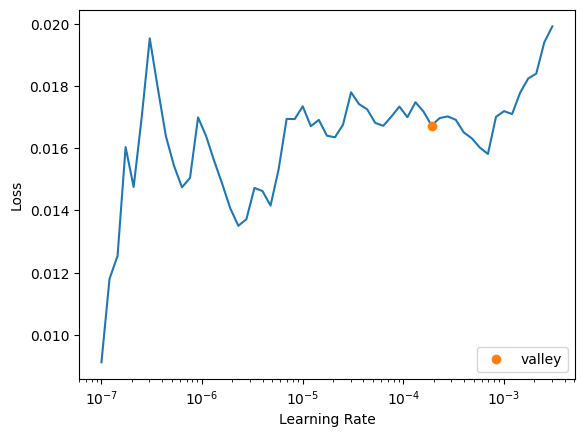

In [17]:
# Use the best performing CNN model from the model selection. 
# Will continue training the model from where is left off.
learn = best_cnn_model

# Add DiceMulti (Macro F1) metric to the learner.
# According to the Fastai documentation this is in a multi-class setting equivalent to the macro F1 score.
learn.metrics = [F1Score(average='macro'), BalancedAccuracy()]

# Find the best learning rate. Turn of the plot.
with learn.no_logging():
    lrs = learn.lr_find()

# Define multiple callbacks for training:
# 1. MixedPrecision: Uses mixed precision training, which can lower training time.
# 2. SaveModelCallback: Saves the model whenever there is an improvement in the dice_multi metric.
# 3. ReduceLROnPlateau: Reduces learning rate when the dice_multi metric does not improve for 2 epochs.
# 4. EarlyStoppingCallback: Stops the training if the dice_multi metric does not improve for 3 epochs. 
cbs = [
    MixedPrecision(),
    SaveModelCallback(monitor="f1_score", comp=np.greater, min_delta=0.001),
    ReduceLROnPlateau(monitor="f1_score", comp=np.greater, min_delta=0.001, patience=2),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, min_delta=0.001, patience=3),
]

# Continue to fine-tune the model for up to 15 epochs.
learn.fine_tune(15, base_lr=lrs.valley, cbs=cbs)

#### 6.2 Traditional Model

In [18]:
# Define parameter grids for all the traditional models tested (except dummyclassifier).
param_grids = {    
    'XGBoost': {
        'learning_rate': [0.1, 0.3],
        'max_depth': [3, 6],
        'min_child_weight': [1, 5]
    },
    'Logistic Regression': {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': [0.01, 0.1, 1, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
    'Random Forest': {
        'n_estimators': [10, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 50, 100],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    },
    'k-Nearest Neighbors': {
        'n_neighbors': [3, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]
    }
}

# Get the best traditional model name based on the model selection.
model_name = best_traditional_name

# Check if the model is in the param_grids dictionary.
if model_name not in param_grids:
    raise ValueError(f"No parameter grid found for {model_name}.")
    
# Select the correct parameter grid.
param_grid = param_grids[model_name]

# Initialize GridSearchCV.
grid_search = GridSearchCV(best_traditional_model, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)

# Run the grid search on the training data.
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found.
best_params = grid_search.best_params_

# Get the best model (estimator) found. This one is refitted on the whole training dataset. 
best_traditional_model_tuned = grid_search.best_estimator_

# Get the macro F1 score.
best_score = grid_search.best_score_

In [19]:
# Print the parameters and F1 score of the best performing traditional model.
print(f"The best hyperparameters from the grid_search for {model_name} are: {best_params}")
print(f"The best macro F1 score for {model_name} is: {best_score*100:6.2f}")

The best hyperparameters from the grid_search for XGBoost are: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1}
The best macro F1 score for XGBoost is:  94.48


## 7. Evaluation and Results

#### 7.1 Make Predictions on Test Set

In [20]:
# Create a test dataloader from the test data. It loads images and their labels.
test_dl = learn.dls.test_dl(get_image_files(test_data), with_labels=True)

# Get predictions and target labels from the best CNN model on the test dataset. 
preds_cnn, targets_cnn = learn.get_preds(dl=test_dl)

# Convert raw class prediction probabilities to class labels by taking the maximum value along dimension 1.
preds_cnn = preds_cnn.argmax(dim=1)

# Predictions and targets are ordered in lexicographic order. We want them ordered from 0 to 16 to make it nicer.
# Define the wanted order of the labels.
wanted_order = list(range(17))

# Get the current order from the models vocabulary.
current_order = [int(label) for label in learn.dls.vocab]

# Create a mapping of wanted_order to current_order.
label_mapping = {wanted_order: current_label for wanted_order, current_label in zip(wanted_order, current_order)}

# Reorder the targets and predictions using the mapping.
reordered_targets_cnn = np.array([label_mapping[label.item()] for label in targets_cnn])
reordered_preds_cnn = np.array([label_mapping[label.item()] for label in preds_cnn])

In [21]:
# Get predictions from the best traditional model on the test dataset. 
preds_traditional = best_traditional_model_tuned.predict(X_test)

# Create a list of the labels.
labels = list(range(17))

#### 7.2 Confusion Matrix for CNN Model

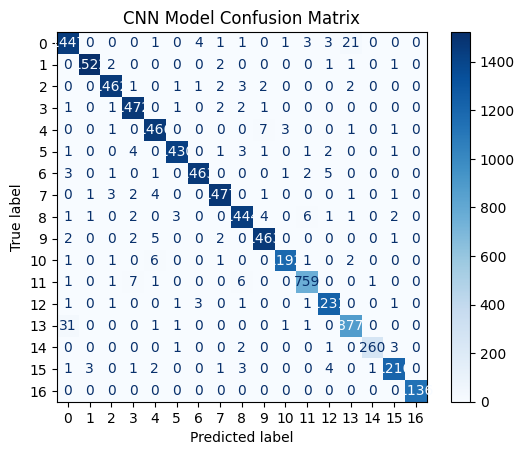

In [22]:
# Create the confusion matrix based on the predictions from the traditional model and the targets.
cm_cnn = confusion_matrix(reordered_targets_cnn, reordered_preds_cnn)

# Display the confusion matrix.
disp_traditional = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=labels)
disp_traditional.plot(cmap='Blues')
plt.title('CNN Model Confusion Matrix')
plt.show()

#### 7.3 Confusion Matrix for Traditional Model

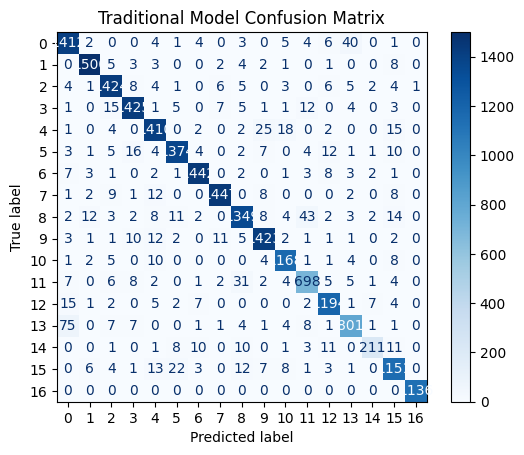

In [23]:
# Create the confusion matrix based on the predictions from the traditional model and the targets.
cm_traditional = confusion_matrix(y_test, preds_traditional)

# Display the confusion matrix.
disp_traditional = ConfusionMatrixDisplay(confusion_matrix=cm_traditional, display_labels=labels)
disp_traditional.plot(cmap='Blues')
plt.title('Traditional Model Confusion Matrix')
plt.show()

#### 7.4 Misclassified Images

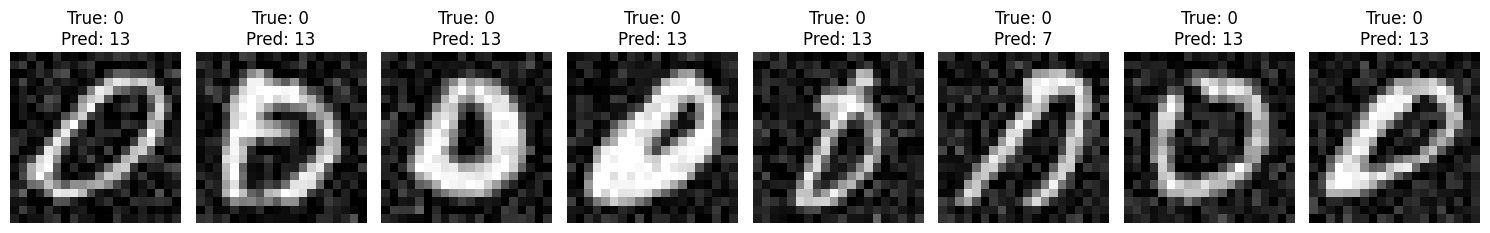

In [24]:
# Get the indices of misclassified classes.
misclassified_idx = (preds_cnn != targets_cnn).nonzero().squeeze(-1)

# Chose number of images to display. Will display up to 8 images.
n = min(8, len(misclassified_idx))

# Create a figure to display these images.
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(15, 3))

# Loop though each of these images.
for i, idx in enumerate(misclassified_idx[:n]):
    # Get the image from the dataset. Ignore the label since we already have it.
    img, _ = test_dl.dataset[idx]
    
    # Get the true and predicted class for the image.
    true_class = targets_cnn[idx].item()
    pred_class = preds_cnn[idx].item()
    
    # Display the image with the true and predicted class as the title.
    img.show(ax=axes[i], title=f"True: {learn.dls.vocab[true_class]}\nPred: {learn.dls.vocab[pred_class]}")

# Adjust to a tighter layout and render the figure.
plt.tight_layout()
plt.show()

#### 7.5 Performance Metrics on Test Data

In [25]:
# Display the reordered classification report for the CNN model.
print("-"*60)
print("Classification Report for the CNN Model:")
print("-"*60)
print(classification_report(reordered_targets_cnn, reordered_preds_cnn, target_names=[str(i) for i in range(17)]))
print("\n")

# Display the classification report for the traditional model.
print("-"*60)
print("Classification Report for the Traditional Model:")
print("-"*60)
print(classification_report(y_test, preds_traditional, target_names=[str(i) for i in range(17)]))

------------------------------------------------------------
Classification Report for the CNN Model:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1482
           1       1.00      1.00      1.00      1529
           2       0.99      0.99      0.99      1474
           3       0.99      0.99      0.99      1480
           4       0.99      0.99      0.99      1479
           5       0.99      0.99      0.99      1444
           6       0.99      0.99      0.99      1476
           7       0.99      0.99      0.99      1490
           8       0.99      0.99      0.99      1465
           9       0.99      0.99      0.99      1475
          10       0.99      0.99      0.99      1204
          11       0.98      0.98      0.98       776
          12       0.99      0.99      0.99      1240
          13       0.97      0.96      0.96       912
          14       0.99   

In [26]:
# Calculate the macro F1 score and balanced accuracy for the CNN model.
cnn_macro_f1 = f1_score(targets_cnn, preds_cnn, average='macro')
cnn_balanced_accuracy = balanced_accuracy_score(targets_cnn, preds_cnn)

# Calculate the macro F1 score and balanced accuracy for the traditional model.
traditional_macro_f1 = f1_score(y_test, preds_traditional, average='macro')
traditional_balanced_accuracy = balanced_accuracy_score(y_test, preds_traditional)

# Print the metrics.
print("Metrics            |  CNN Model  |  Traditional Model  |")
print("-" * 56)
print(f"Macro F1 Score     |   {cnn_macro_f1*100:6.2f}%   |       {traditional_macro_f1*100:6.2f}%       |")
print(f"Balanced Accuracy  |   {cnn_balanced_accuracy*100:6.2f}%   |       {traditional_balanced_accuracy*100:6.2f}%       |")

Metrics            |  CNN Model  |  Traditional Model  |
--------------------------------------------------------
Macro F1 Score     |    98.78%   |        94.65%       |
Balanced Accuracy  |    98.72%   |        94.33%       |
